In [3]:
import glob
import os
import pdb

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from numpy import random
from torch.utils.data import (
    DataLoader,
    Dataset,
    SubsetRandomSampler,
    TensorDataset,
)
from torchvision.utils import save_image

from models import Unet

torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.chdir(
    r"C:\Users\avs20\Documents\GitHub\DeepEnsampleGUI\napari-threshold\Unet_training"
)


def random_cutout(image, label, max_h=50, max_w=50):
    """
    Apply random cutout to both image and label.
    Args:
        image: The input image tensor.
        label: The label tensor.
        max_h: Maximum height of the cutout box.
        max_w: Maximum width of the cutout box.
    Returns:
        image: Image after cutout.
        label: Label after cutout.
    """
    _, h, w = image.shape
    cutout_height = random.randint(10, max_h)
    cutout_width = random.randint(10, max_w)

    # Randomly choose the position for the cutout
    top = random.randint(0, h - cutout_height)
    left = random.randint(0, w - cutout_width)

    # Apply the cutout to the image and label (set to 0)
    image[:, top : top + cutout_height, left : left + cutout_width] = 0
    label[:, top : top + cutout_height, left : left + cutout_width] = 0

    return image, label


def adjust_brightness(image, label, brightness_factor=0.2):
    """
    Adjust the brightness of the image and label.
    Args:
        image: The input image tensor.
        label: The label tensor.
        brightness_factor: Factor by which brightness is adjusted.
    Returns:
        image: Image after brightness adjustment.
        label: Label after brightness adjustment.
    """
    image = TF.adjust_brightness(
        image, 1 + (random.random() * 2 - 1) * brightness_factor
    )
    # Note: Brightness doesn't affect the label, so we leave it unchanged
    return image, label


import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF


def random_jitter(image, max_jitter=0.1):
    """
    Apply random jittering to an image by adding noise to its pixel values.
    Args:
        image: The input image tensor.
        max_jitter: The maximum amount of jitter to apply to each pixel.
    Returns:
        image: The image with jitter applied.
    """
    # Generate random noise with a normal distribution
    noise = torch.randn_like(image) * max_jitter  # Gaussian noise
    image = image + noise

    # Clip the values to be in the valid range [0, 1] for images
    image = torch.clamp(image, 0, 1)

    return image


def motion_blur(image, kernel_size=5, angle=45):
    """
    Apply motion blur to an image using a convolution with a motion blur kernel.
    Args:
        image: The input image tensor.
        kernel_size: The size of the blur kernel.
        angle: The angle of the motion.
    Returns:
        image: The image after motion blur.
    """
    # Create motion blur kernel
    kernel = torch.zeros((kernel_size, kernel_size))

    # Define the direction of the blur (this could be any angle, here we use horizontal motion)
    center = kernel_size // 2
    angle_rad = torch.tensor(angle * torch.pi / 180)  # Convert to radians

    # Apply a simple horizontal motion blur
    for i in range(kernel_size):
        kernel[center, i] = 1

    # Normalize the kernel
    kernel = kernel / kernel.sum()

    # Reshape kernel for convolution (batch size, channels, kernel size)
    kernel = kernel.unsqueeze(0).unsqueeze(
        0
    )  # Shape (1, 1, kernel_size, kernel_size)

    # Apply the kernel using convolution
    blurred_image = F.conv2d(
        image.unsqueeze(0), kernel, padding=kernel_size // 2
    )
    return blurred_image.squeeze(0)


class facemapdataset(Dataset):
    # def __init__(self, data_file="data/dolensek_facemap_softlabels_224.pt",
    # def __init__(self, data_file="data\dolensek_facemap_softlabels_224_TEST_DIF_KP.pt",
    def __init__(
        self,
        data_file=r'C:\Users\avs20\Documents\GitHub\DeepEnsampleGUI\napari-threshold\Unet_training\data\dataset2.pt',
        transform=None,
        rotation_degrees=(
            15,
            30,
        ),  # Rotation angle range from 15 to 30 degrees
        zoom_range=(
            0.8,
            1.5,
        ),  # Zoom range from 0.8 (zoom out) to 1.5 (zoom in)
        blur_radius=(1, 2),  # Tuple for Gaussian blur radius range
        cutout_prob=0.2,  # Probability of applying cutout
        brightness_prob=0.2,  # Probability of applying brightness adjustment
        brightness_factor=0.5,  # Max factor for brightness adjustment
        motion_blur_prob=0.2,  # Probability of applying motion blur
        motion_blur_kernel_size=5,  # Size of the motion blur kernel
        motion_blur_angle=45,  # Angle of the motion blur
        jitter_prob=0.2,  # Probability of applying random jitter
        jitter_max=0.1,
    ):  # Maximum jitter value (standard deviation)
        super().__init__()
        self.transform = transform
        self.rotation_degrees = rotation_degrees
        self.zoom_range = zoom_range
        self.blur_radius = blur_radius
        self.cutout_prob = cutout_prob
        self.brightness_prob = brightness_prob
        self.brightness_factor = brightness_factor
        self.motion_blur_prob = motion_blur_prob
        self.motion_blur_kernel_size = motion_blur_kernel_size
        self.motion_blur_angle = motion_blur_angle
        self.jitter_prob = jitter_prob
        self.jitter_max = jitter_max
        # self.data, _, self.targets = torch.load(data_file)
        self.data, self.targets = torch.load(data_file)

    # def __len__(self):
    #    return len(self.data) * 5  # Return length * 5 for augmented versions
    def __len__(self):
        return len(self.data) * 10  # Return length * 10 for augmented versions

    def __getitem__(self, index):
        # Ensure the index stays within bounds by using modulo with the original dataset size
        base_index = index % len(
            self.data
        )  # This will prevent out-of-bounds errors
        aug_type = index // len(
            self.data
        )  # This will determine which augmentation to apply

        # Load the original image and label
        image, label = (
            self.data[base_index].clone(),
            self.targets[base_index].clone(),
        )

        # Apply the augmentation based on the `aug_type`
        if self.transform is not None:
            if aug_type == 1:  # Flipping
                image = image.flip([2])
                label = label.flip([2])
            elif aug_type == 2:  # Rotation
                angle = random.uniform(
                    -self.rotation_degrees[1], self.rotation_degrees[1]
                )
                image = TF.rotate(image, angle)
                label = TF.rotate(label, angle)
            elif aug_type == 3:  # Zooming
                scale_factor = random.uniform(
                    self.zoom_range[0], self.zoom_range[1]
                )
                image = self.zoom(image, scale_factor)
                label = self.zoom(label, scale_factor)
            elif aug_type == 4:  # Gaussian Blur
                radius = (
                    torch.rand(1).item()
                    * (self.blur_radius[1] - self.blur_radius[0])
                    + self.blur_radius[0]
                )
                image = TF.gaussian_blur(image, kernel_size=int(radius))
                # Do not apply blur to the label

            # Apply random cutout with probability
            if random.random() < self.cutout_prob:
                image, label = random_cutout(image, label)

            # Apply random brightness adjustment with probability
            if random.random() < self.brightness_prob:
                image, _ = adjust_brightness(
                    image, label, self.brightness_factor
                )
                # Note that the label is not being adjusted, only the image

            # Apply motion blur with probability
            if random.random() < self.motion_blur_prob:
                image = motion_blur(
                    image, self.motion_blur_kernel_size, self.motion_blur_angle
                )

            # Apply random jittering with probability
            if random.random() < self.jitter_prob:
                image = random_jitter(image, self.jitter_max)

        return image, label

    def zoom(self, img, scale_factor):
        # Calculate new dimensions
        _, h, w = img.shape
        new_h, new_w = int(h * scale_factor), int(w * scale_factor)

        # Resize and center-crop back to the original size
        img = TF.resize(img, [new_h, new_w])
        img = TF.center_crop(img, [h, w])
        return img


# class facemapdataset(Dataset):
#     def __init__(self, data_file="data/dataset.pt", transform=None):
#         super().__init__()

#         self.transform = transform
#         # self.data, _, self.targets = torch.load(data_file)
#         self.data, self.targets = torch.load(data_file)

#     def __len__(self):
#         return len(self.targets)

#     def __getitem__(self, index):
#         image, label = self.data[index].clone(), self.targets[index].clone()
#         if (self.transform is not None) and (torch.rand(1) > 0.5):
#             image = image.flip([2])
#             label = label.flip([2])
#         return image, label


### Make dataset
dataset = facemapdataset(transform="flip")

x = dataset[0][0]
dim = x.shape[-1]
print("Using %d size of images" % dim)
N = len(dataset)
train_sampler = SubsetRandomSampler(np.arange(int(0.6 * N)))
valid_sampler = SubsetRandomSampler(np.arange(int(0.6 * N), int(0.8 * N)))
test_sampler = SubsetRandomSampler(np.arange(int(0.8 * N), N))
batch_size = 4
# Initialize loss and metrics
loss_fun = torch.nn.MSELoss(reduction="sum")

# Initiliaze input dimensions
num_train = len(train_sampler)
num_valid = len(valid_sampler)
num_test = len(test_sampler)
print(
    "Num. train = %d, Num. val = %d, Num. test = %d"
    % (num_train, num_valid, num_test)
)

# Initialize dataloaders
loader_train = DataLoader(
    dataset=dataset,
    drop_last=False,
    num_workers=0,
    batch_size=batch_size,
    pin_memory=True,
    sampler=train_sampler,
)
loader_valid = DataLoader(
    dataset=dataset,
    drop_last=True,
    num_workers=0,
    batch_size=batch_size,
    pin_memory=True,
    sampler=valid_sampler,
)
loader_test = DataLoader(
    dataset=dataset,
    drop_last=True,
    num_workers=0,
    batch_size=1,
    pin_memory=True,
    sampler=test_sampler,
)

nValid = len(loader_valid)
nTrain = len(loader_train)
nTest = len(loader_test)

### hyperparam
lr = 5e-4
num_epochs = 100

# num_input_channels = 1  # Change this to the desired number of input channels
# num_output_classes = 24  # Change this to the desired number of output classes


model = Unet()
# timm.create_model('vit_base_patch8_224',
#        pretrained=True,in_chans=1,num_classes=num_output_classes)

model = model.to(device)
nParam = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters:%2f M" % (nParam / 1e6))

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
minLoss = 1e6
convIter = 0
patience = 100
train_loss = []
valid_loss = []

for epoch in range(num_epochs):
    tr_loss = 0
    for i, (inputs, labels) in enumerate(loader_train):
        inputs = inputs.to(device)
        labels = labels.to(device)
        scores, _ = model(inputs)

        loss = loss_fun((scores), ((labels)))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(
            "Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}".format(
                epoch + 1, num_epochs, i + 1, nTrain, loss.item()
            )
        )
        tr_loss += loss.item()
    train_loss.append(tr_loss / (i + 1))

    with torch.no_grad():
        val_loss = 0
        for i, (inputs, labels) in enumerate(loader_valid):
            inputs = inputs.to(device)
            labels = labels.to(device)
            scores, fmap = model(inputs)
            loss = loss_fun((scores), ((labels)))
            val_loss += loss.item()
        val_loss = val_loss / (i + 1)

        valid_loss.append(val_loss)

        print("Val. loss :%.4f" % val_loss)

        labels = labels.squeeze().detach().cpu().numpy()
        scores = scores.squeeze().detach().cpu().numpy()
        img = inputs.squeeze().detach().cpu().numpy()
        fmap = inputs.mean(1).squeeze().detach().cpu().numpy()

        plt.clf()
        plt.figure(figsize=(16, 12))
        for i in range(batch_size):
            plt.subplot(batch_size, 3, 3 * i + 1)
            plt.imshow(labels[i])
            plt.subplot(batch_size, 3, 3 * i + 2)
            plt.imshow(scores[i] * img[i])
            plt.subplot(batch_size, 3, 3 * i + 3)
            plt.imshow(fmap[i])

        plt.tight_layout()

        plt.savefig("epoch_%03d.jpg" % epoch)
        plt.close()

        if minLoss > val_loss:
            convEpoch = epoch
            minLoss = val_loss
            convIter = 0
            # torch.save(model.state_dict(),'models/best_model.pt')
        else:
            convIter += 1

        if convIter == patience:
            print(
                "Converged at epoch %d with val. loss %.4f"
                % (convEpoch + 1, minLoss)
            )
            break
plt.clf()
plt.plot(train_loss, label="Training")
plt.plot(valid_loss, label="Valid")
plt.plot(convEpoch, valid_loss[convEpoch], "x", label="Final Model")
plt.legend()
plt.tight_layout()
plt.savefig("loss_curve.pdf")
plt.close()

### Load best model for inference
with torch.no_grad():
    val_loss = 0

    for i, (inputs, labels) in enumerate(loader_test):
        inputs = inputs.to(device)
        labels = labels.to(device)
        scores, fmap = model(inputs)
        loss = loss_fun((scores), ((labels)))
        val_loss += loss.item()

        img = inputs.squeeze().detach().cpu().numpy()
        pred = scores.squeeze().detach().cpu().numpy()
        labels = labels.squeeze().cpu().numpy()
        fmap = fmap.mean(1).squeeze().cpu().numpy()

        plt.clf()
        plt.figure(figsize=(12, 4))
        plt.subplot(141)
        plt.imshow(img, cmap="gray")
        plt.subplot(142)
        plt.imshow(labels)
        plt.subplot(143)
        plt.imshow(pred)
        plt.subplot(144)
        plt.imshow(fmap)

        plt.tight_layout()
        plt.savefig("preds/test_%03d.jpg" % i)
        plt.close()

    val_loss = val_loss / (i + 1)

    print("Test. loss :%.4f" % val_loss)


Using 388 size of images
Num. train = 222, Num. val = 74, Num. test = 74
Number of parameters:0.029289 M
Epoch [1/100], Step [1/56], Loss: 126.1236
Epoch [1/100], Step [2/56], Loss: 76.4727
Epoch [1/100], Step [3/56], Loss: 57.7516
Epoch [1/100], Step [4/56], Loss: 47.6388
Epoch [1/100], Step [5/56], Loss: 42.9207
Epoch [1/100], Step [6/56], Loss: 39.7305
Epoch [1/100], Step [7/56], Loss: 22.6739
Epoch [1/100], Step [8/56], Loss: 22.4541
Epoch [1/100], Step [9/56], Loss: 18.1246
Epoch [1/100], Step [10/56], Loss: 19.1811
Epoch [1/100], Step [11/56], Loss: 11.6707
Epoch [1/100], Step [12/56], Loss: 12.8377
Epoch [1/100], Step [13/56], Loss: 8.0796
Epoch [1/100], Step [14/56], Loss: 12.6915
Epoch [1/100], Step [15/56], Loss: 12.9605
Epoch [1/100], Step [16/56], Loss: 8.3367
Epoch [1/100], Step [17/56], Loss: 7.8125
Epoch [1/100], Step [18/56], Loss: 9.0811
Epoch [1/100], Step [19/56], Loss: 5.6609
Epoch [1/100], Step [20/56], Loss: 5.0839
Epoch [1/100], Step [21/56], Loss: 6.0564
Epoch [

<Figure size 640x480 with 0 Axes>

In [28]:
### Load best model for inference
with torch.no_grad():
    val_loss = 0

    for i, (inputs, labels) in enumerate(loader_test):
        inputs = inputs.to(device)
        labels = labels.to(device)
        scores, fmap = model(inputs)
        loss = loss_fun((scores), ((labels)))
        val_loss += loss.item()

        img = inputs.squeeze().detach().cpu().numpy()
        pred = scores.squeeze().detach().cpu().numpy()
        labels = labels.squeeze().cpu().numpy()
        fmap = fmap.mean(1).squeeze().cpu().numpy()

        plt.clf()
        plt.figure(figsize=(12, 4))
        plt.subplot(141)
        plt.imshow(img, cmap="gray")
        plt.subplot(142)
        plt.imshow(labels)
        plt.subplot(143)
        plt.imshow(pred)
        plt.subplot(144)
        plt.imshow(fmap)

        plt.tight_layout()
        plt.savefig("preds/test_%03d.jpg" % i)
        plt.close()

    val_loss = val_loss / (i + 1)

    print("Test. loss :%.4f" % val_loss)

Test. loss :0.0139


<Figure size 640x480 with 0 Axes>

In [34]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF
import random

class facemapdataset(Dataset):
    def __init__(self, data_file=r'C:\Users\avs20\Documents\GitHub\DeepEnsampleGUI\napari-threshold\Unet_training\data\single_image.pt', transform=None):
        super().__init__()
        self.transform = transform
        # Load the data (single image tensor)
        self.data= torch.load(data_file)

    def __len__(self):
        return len(self.data)  # We are using a single image dataset, no augmentation.

    def __getitem__(self, index):
        # Load the image and label
        image = self.data[index].clone()

        # No augmentation or transformation is applied to the image or label
        return image


# Initialize the dataset
dataset = facemapdataset()

# Example of retrieving a sample from the dataset
image = dataset[0]
print(f"Image shape: {image.shape}")


Image shape: torch.Size([244, 388])


In [ ]:
### Load best model for inference


with torch.no_grad():
    val_loss = 0

    inputs = image.to(device)
    #labels = labels.to(device)
    scores, fmap = model(inputs)
    #loss = loss_fun((scores), ((labels)))
    val_loss += loss.item()

    img = inputs.squeeze().detach().cpu().numpy()
    pred = scores.squeeze().detach().cpu().numpy()
    #labels = labels.squeeze().cpu().numpy()
    fmap = fmap.mean(1).squeeze().cpu().numpy()

    plt.clf()
    plt.figure(figsize=(12, 4))
    plt.subplot(141)
    plt.imshow(img, cmap="gray")
    #plt.subplot(142)
    #plt.imshow(labels)
    plt.subplot(143)
    plt.imshow(pred)
    plt.subplot(144)
    plt.imshow(fmap)

    plt.tight_layout()
    plt.savefig("preds/test_%03d.jpg" % i)
    plt.close()

    val_loss = val_loss / (i + 1)

    print("Test. loss :%.4f" % val_loss)

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [244, 388]

In [37]:
import torch
import matplotlib.pyplot as plt

# Assuming image is already loaded
image = dataset[0]  # Shape: [244, 388]
image = image.unsqueeze(0).unsqueeze(0)  # Now the shape is [1, 1, 244, 388]

# Move the image to the device (GPU or CPU)
inputs = image.to(device)

# Perform inference with the model
with torch.no_grad():
    scores, fmap = model(inputs)

    # Optionally, process the results (e.g., loss, visualization)
    img = inputs.squeeze().detach().cpu().numpy()
    pred = scores.squeeze().detach().cpu().numpy()
    fmap = fmap.mean(1).squeeze().cpu().numpy()

    # Plotting the results
    plt.clf()
    plt.figure(figsize=(12, 4))
    plt.subplot(141)
    plt.imshow(img, cmap="gray")
    plt.subplot(143)
    plt.imshow(pred)
    plt.subplot(144)
    plt.imshow(fmap)

    plt.tight_layout()
    plt.savefig("preds/test_%03d.jpg" % i)
    plt.close()

    # Compute and print the validation loss
    val_loss = val_loss / (i + 1)
    print("Test. loss :%.4f" % val_loss)


Test. loss :0.0000


<Figure size 640x480 with 0 Axes>

In [ ]:
#create single image .pt file
import torch
from PIL import Image
import torchvision.transforms as transforms

# Define the path to your single image
img_path = r'C:\Users\avs20\Documents\GitHub\DeepEnsampleGUI\napari-threshold\Unet_training\frame_0002.jpg'  # Replace with your image path

# Define any transformations (optional, for example, converting to tensor)
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
])

# Load the single image
img = Image.open(img_path).convert('L')  # Convert to grayscale ('L')

# Resize the image
resize_factor = 0.2
min_size = 32
new_width = max(int(img.width * resize_factor), min_size)
new_height = max(int(img.height * resize_factor), min_size)

# Ensure the resized dimensions are even
new_width += new_width % 2  # Make width even
new_height += new_height % 2  # Make height even

img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)

# Apply the transformation (e.g., converting to tensor)
img_tensor = transform(img)

# Define the save path for the .pt file
save_path = r'C:\Users\avs20\Documents\GitHub\DeepEnsampleGUI\napari-threshold\Unet_training\data\single_image.pt'  # Change to the path where you want to save the file

# Save the image tensor to the .pt file
torch.save(img_tensor, save_path)
print(f"Image saved to {save_path}")



Image saved to C:\Users\avs20\Documents\GitHub\DeepEnsampleGUI\napari-threshold\Unet_training\data\single_image.pt


In [5]:
torch.save(model, 'models/best_model_complete.pth')  # Saves the entire model


In [6]:
# Assuming `model` is an instance of your `Unet` model
torch.save(model.state_dict(), 'model_weights.pth')


In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from models import Unet  # Import the custom Unet class (adjust import as needed)

# Step 1: Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize your Unet model
model = Unet()

# Load the model weights
model.load_state_dict(torch.load(r'C:\Users\avs20\Documents\GitHub\DeepEnsampleGUI\napari-threshold\Unet_training\model_weights.pth', map_location=device, weights_only=False))
model.eval()  # Set the model to evaluation mode

# Step 2: Load and preprocess the input image
image_path = r'C:\Users\avs20\Documents\GitHub\DeepEnsampleGUI\napari-threshold\Unet_training\test_img.jpg'  # Replace with the path to your image

# Open image using PIL
# Open image using PIL and convert to grayscale
image = Image.open(image_path)  # 'L' mode for grayscale

# Define the necessary transformations for the input image
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to the same size the model was trained on
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image (adjust if needed)
])

# Apply the transformations to the input image
input_image = transform(image).unsqueeze(0).to(device)  # Add a batch dimension and move to the appropriate device

# Step 3: Make the prediction
with torch.no_grad():
    output = model(input_image)  # Forward pass through the model

# Step 4: Post-process the output (e.g., if the output is a segmentation map)
output = output.squeeze().cpu().numpy()  # Remove the batch dimension and move the output to CPU

# Step 5: Display the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(output, cmap='gray')  # Assuming the output is a single-channel (grayscale) segmentation map
plt.title('Model Output')

plt.tight_layout()
plt.show()



RuntimeError: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]

In [26]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from models import Unet  # Import your custom Unet class

# Function to load a .jpg image, apply necessary transformations, and run inference
def load_and_infer(image_path, model, device):
    # Step 1: Open the image
    image = Image.open(image_path).convert('L')  # Convert to grayscale ('L' mode)

    # Define the resize factor (same as used during dataset creation)
    resize_factor = 0.2  # This is the resize factor you used in dataset creation
    min_size = 32  # This is the minimum size you used to prevent the image from being too small

    # Resize the image
    new_width = max(int(image.width * resize_factor), min_size)
    new_height = max(int(image.height * resize_factor), min_size)
    new_width += new_width % 2  # Make width even
    new_height += new_height % 2  # Make height even
    image = image.resize((new_width, new_height), Image.Resampling.LANCZOS)

    # Step 2: Define transformations
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert image to tensor
        #transforms.Normalize(mean=[0.485], std=[0.229]),  # Normalize based on the mean and std from training
    ])

    # Apply transformations
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Step 3: Make the prediction
    with torch.no_grad():
        output = model(image_tensor)  # Forward pass through the model

    # Step 4: Post-process the output
    output = output.squeeze().cpu().numpy()  # Remove the batch dimension and move the output to CPU

    # Step 5: Display the results
    plt.figure(figsize=(10, 5))

    # Display the original image
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')

    # Display the model's output (assuming it's a segmentation map)
    plt.subplot(1, 2, 2)
    plt.imshow(output, cmap='gray')
    plt.title('Model Output')

    plt.tight_layout()
    plt.show()

# Step 2: Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the Unet model
model = Unet()

# Load the model weights
model.load_state_dict(torch.load(r'C:\Users\avs20\Documents\GitHub\DeepEnsampleGUI\napari-threshold\Unet_training\model_weights.pth', map_location=device))
model.eval()  # Set the model to evaluation mode

# Step 3: Run inference on a .jpg image
image_path = r'C:\Users\avs20\Documents\GitHub\DeepEnsampleGUI\napari-threshold\Unet_training\frame_0002.jpg'  # Replace with the path to your .jpg image
load_and_infer(image_path, model, device)


AttributeError: 'tuple' object has no attribute 'squeeze'

Model output is a tuple. Extracting the first element.
Output shape: torch.Size([1, 1, 244, 388])


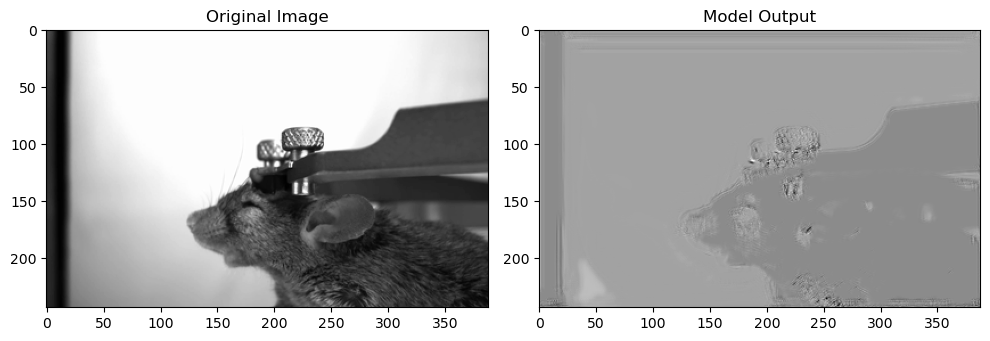

In [27]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from models import Unet  # Import your custom Unet class

# Function to load a .jpg image, apply necessary transformations, and run inference
def load_and_infer(image_path, model, device):
    # Step 1: Open the image
    image = Image.open(image_path).convert('L')  # Convert to grayscale ('L' mode)

    # Define the resize factor (same as used during dataset creation)
    resize_factor = 0.2  # This is the resize factor you used in dataset creation
    min_size = 32  # This is the minimum size you used to prevent the image from being too small

    # Resize the image
    new_width = max(int(image.width * resize_factor), min_size)
    new_height = max(int(image.height * resize_factor), min_size)
    new_width += new_width % 2  # Make width even
    new_height += new_height % 2  # Make height even
    image = image.resize((new_width, new_height), Image.Resampling.LANCZOS)

    # Step 2: Define transformations
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert image to tensor
        transforms.Normalize(mean=[0.485], std=[0.229]),  # Normalize based on the mean and std from training
    ])

    # Apply transformations
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Step 3: Make the prediction
    with torch.no_grad():
        output = model(image_tensor)  # Forward pass through the model

    # Check if the output is a tuple (e.g., with auxiliary outputs)
    if isinstance(output, tuple):
        print("Model output is a tuple. Extracting the first element.")
        output = output[0]  # Extract the first element if it's a tuple
    else:
        print("Model output is not a tuple.")

    print(f"Output shape: {output.shape}")  # Check the shape of the output

    # Step 4: Post-process the output
    output = output.squeeze().cpu().numpy()  # Remove the batch dimension and move the output to CPU

    # Step 5: Display the results
    plt.figure(figsize=(10, 5))

    # Display the original image
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')

    # Display the model's output (assuming it's a segmentation map)
    plt.subplot(1, 2, 2)
    plt.imshow(output, cmap='gray')
    plt.title('Model Output')

    plt.tight_layout()
    plt.show()

# Step 2: Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the Unet model
model = Unet()

# Load the model weights
model.load_state_dict(torch.load(r'C:\Users\avs20\Documents\GitHub\DeepEnsampleGUI\napari-threshold\Unet_training\model_weights.pth', map_location=device))
model.eval()  # Set the model to evaluation mode

# Step 3: Run inference on a .jpg image
image_path = r'C:\Users\avs20\Documents\GitHub\DeepEnsampleGUI\napari-threshold\Unet_training\frame_0002.jpg'  # Replace with the path to your .jpg image
load_and_infer(image_path, model, device)
